In [54]:
import os
import numpy as np
from functools import partial
import math
from tqdm import tqdm
import time as time

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io as sio
from astropy.io import fits

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg


True
1
0
NVIDIA A100-PCIE-40GB


In [77]:
# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 4999, "record_iters": False}
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
base_savedir = '/disk/xray0/tl3/outputs/large-scale-UQ/sampling/CRR'
save_dir = base_savedir + '/vars/'
savefig_dir = base_savedir + '/figs/'

img_name = 'CYN' # 'W28' # '3c288' # 'CYN' # 'M31'

# Load img
img_path = '/disk/xray0/tl3/repos/large-scale-UQ/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Load img
img_path = repo_dir + '/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)


# Loading the image and cast it to float
img = np.squeeze(np.copy(img_data[0].data)).astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img


In [78]:
img.shape

(477, 1025)

In [51]:
# Load op from X Cai
op_mask = sio.loadmat(
    repo_dir + '/data/operators_masks/fourier_mask.mat'
)['Ma']

# Matlab's reshape works with 'F'-like ordering
mat_mask = np.reshape(np.sum(op_mask, axis=0), img.shape, order='F').astype(bool)

# Define my torch types
myType = torch.float32
myComplexType = torch.complex64

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape)


dim = 256
phi = luq.operators.MaskedFourier_torch(
    dim=dim, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)


# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))


# %%
# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
f = luq.operators.RealProx_torch()


# %%
# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

sigma_training = 5
t_model = 5
dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(dir_name+exp_name, 'cuda:0', device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

# L_CRR = model.L.detach().cpu().squeeze().numpy()
# print(f"Lipschitz bound {L_CRR:.3f}")

# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")


RuntimeError: The size of tensor a (1025) must match the size of tensor b (256) at non-singleton dimension 4

In [28]:
# CRR parameters
# reg_params = [5e5, 1e6] # [250., 1e3, 5e3, 1e4, 5e4, 1e5]
theta_init = 1e2




[GD] 0 out of 15000 iterations, tol = 0.074123
[GD] converged in 1032 iterations
-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


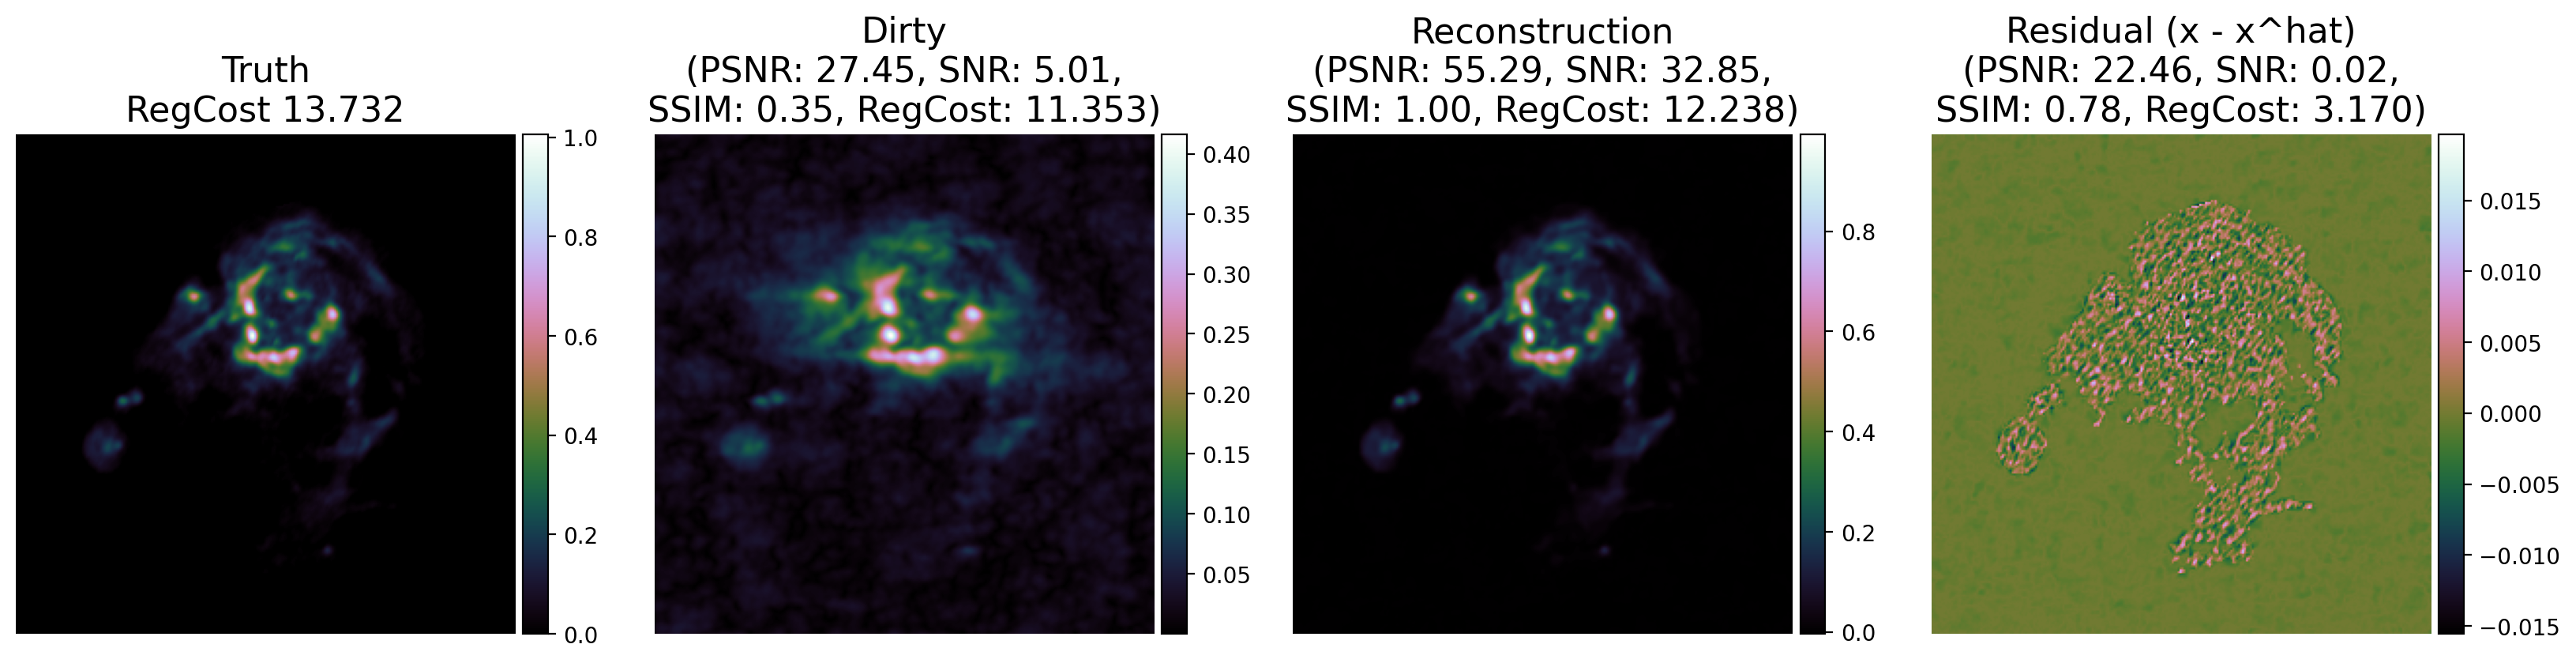

In [29]:
# Prior parameters
lmbd = 5e4
mu = 20

# Compute stepsize
alpha = 0.98 / (g.beta + mu * lmbd * L_CRR)

# initialization
x_hat = torch.clone(x_init)
z = torch.clone(x_init)
t = 1

for it_2 in range(options['iter']):
    x_hat_old = torch.clone(x_hat)
    # grad = g.grad(z.squeeze()) +  lmbd * model(mu * z)
    x_hat = z - alpha *(
        g.grad(z) + lmbd * model(mu * z)
    )
    # Positivity constraint
    x_hat = f.prox(x_hat)
    # Positivity constraint
    # x = torch.clamp(x, 0, None)
    
    t_old = t 
    t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

    if res < options['tol']:
        print("[GD] converged in %d iterations"%(it_2))
        break

    if it_2 % options['update_iter'] == 0:
        print(
            "[GD] %d out of %d iterations, tol = %f" %(            
                it_2,
                options['iter'],
                res,
            )
        )


# %%
np_x_init = to_numpy(x_init)
np_x = np.copy(x)
np_x_hat = to_numpy(x_hat)

images = [np_x, np_x_init, np_x_hat, np_x - np.abs(np_x_hat)]


# %%
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]
fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='cubehelix', vmax=np.nanmax(images[i]), vmin=np.nanmin(images[i]))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i == 0:
        stats_str = '\nRegCost {:.3f}'.format(model.cost(to_tensor(mu * images[i], device=device))[0].item())
    if i > 0:   
        stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f}, RegCost: {:.3f})'.format(
            psnr(np_x, images[i], data_range=np_x.max()-np_x.min()),
            luq.utils.eval_snr(x, images[i]),
            ssim(np_x, images[i], data_range=np_x.max()-np_x.min()),
            model.cost(to_tensor(mu * images[i], device=device))[0].item(),
            )
    labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
# plt.savefig('{:s}{:s}_lmbd_{:.1e}_optim_MAP.pdf'.format(savefig_dir, img_name, lmbd))
# plt.close()
plt.show()


# Image impainting


In [30]:

x_map = torch.clone(x_hat)


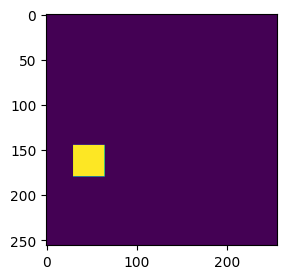

In [31]:
mask_x = [145, 180] # [50,200]# [125, 190]# [145, 180]
mask_y = [30, 65] # [10,150]# [20, 75]# [30, 65]

np_mask_inpainting = np.zeros((img.shape[0], img.shape[1]))
np_mask_inpainting[mask_x[0]:mask_x[1], mask_y[0]:mask_y[1]] = 1

plt.figure(figsize=(3,3))
plt.imshow(np_mask_inpainting)
plt.show()

In [32]:
inpaint_img = to_numpy(x_hat)
inpaint_img[np_mask_inpainting.astype(bool)] = 0

# x_map = torch.clone(x_hat)
mask_inpainting = torch.tensor(
    np_mask_inpainting, dtype=myType, device=device
).reshape((1,1) + img.shape)

x_init_imp = torch.tensor(
    inpaint_img, dtype=myType, device=device,
).reshape((1,1) + img.shape)



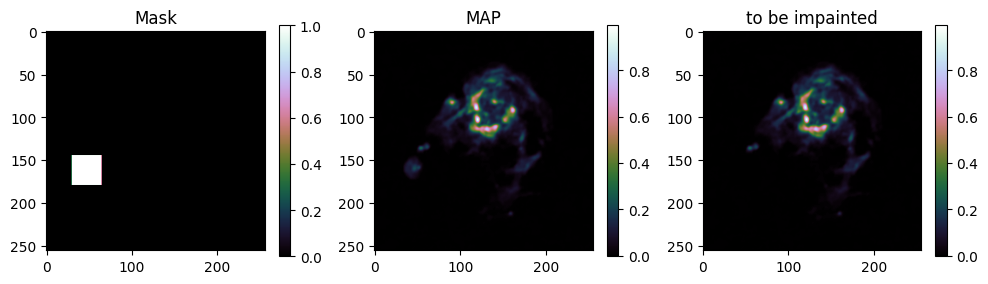

In [33]:

plt.figure(figsize=(12,3))

plt.subplot(131)
plt.imshow(np_mask_inpainting, cmap='cubehelix')
plt.colorbar()
plt.title('Mask')

plt.subplot(132)
plt.imshow(to_numpy(x_map), cmap='cubehelix')
plt.colorbar()
plt.title('MAP')

plt.subplot(133)
plt.imshow(to_numpy(x_init_imp), cmap='cubehelix')
plt.colorbar()
plt.title('to be impainted')

plt.show()



In [34]:
# Inpatinting
options['update_iter'] = 10
options['tol'] = 5e-6
# Prior parameters
lmbd = 5e4
mu = 20

# Compute stepsize
alpha = 0.98 / (g.beta + mu * lmbd * L_CRR)

# initialization
x_hat = torch.clone(x_init_imp)
z = torch.clone(x_init_imp)
t = 1

for it_2 in range(options['iter']):
    x_hat_old = torch.clone(x_hat)
    
    # x_hat = z - alpha *(g.grad(z) + lmbd * model(mu * z))
    x_hat = z - alpha *lmbd * model(mu * z)
    # Positivity constraint
    x_hat = f.prox(x_hat)
    # Positivity constraint
    # x = torch.clamp(x, 0, None)

    x_hat = torch.clone(x_hat) * mask_inpainting + torch.clone(x_map) * (1. - mask_inpainting)
    
    t_old = t 
    t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

    if res < options['tol']:
        print("[GD] converged in %d iterations"%(it_2))
        break

    if it_2 % options['update_iter'] == 0:
        print(
            "[GD] %d out of %d iterations, tol = %f" %(            
                it_2,
                options['iter'],
                res,
            )
        )


[GD] 0 out of 15000 iterations, tol = 0.000044
[GD] 10 out of 15000 iterations, tol = 0.000022
[GD] 20 out of 15000 iterations, tol = 0.000014
[GD] 30 out of 15000 iterations, tol = 0.000006
[GD] converged in 35 iterations


In [35]:


mask_np_img = lambda _x : _x[mask_x[0]:mask_x[1], mask_y[0]:mask_y[1]]


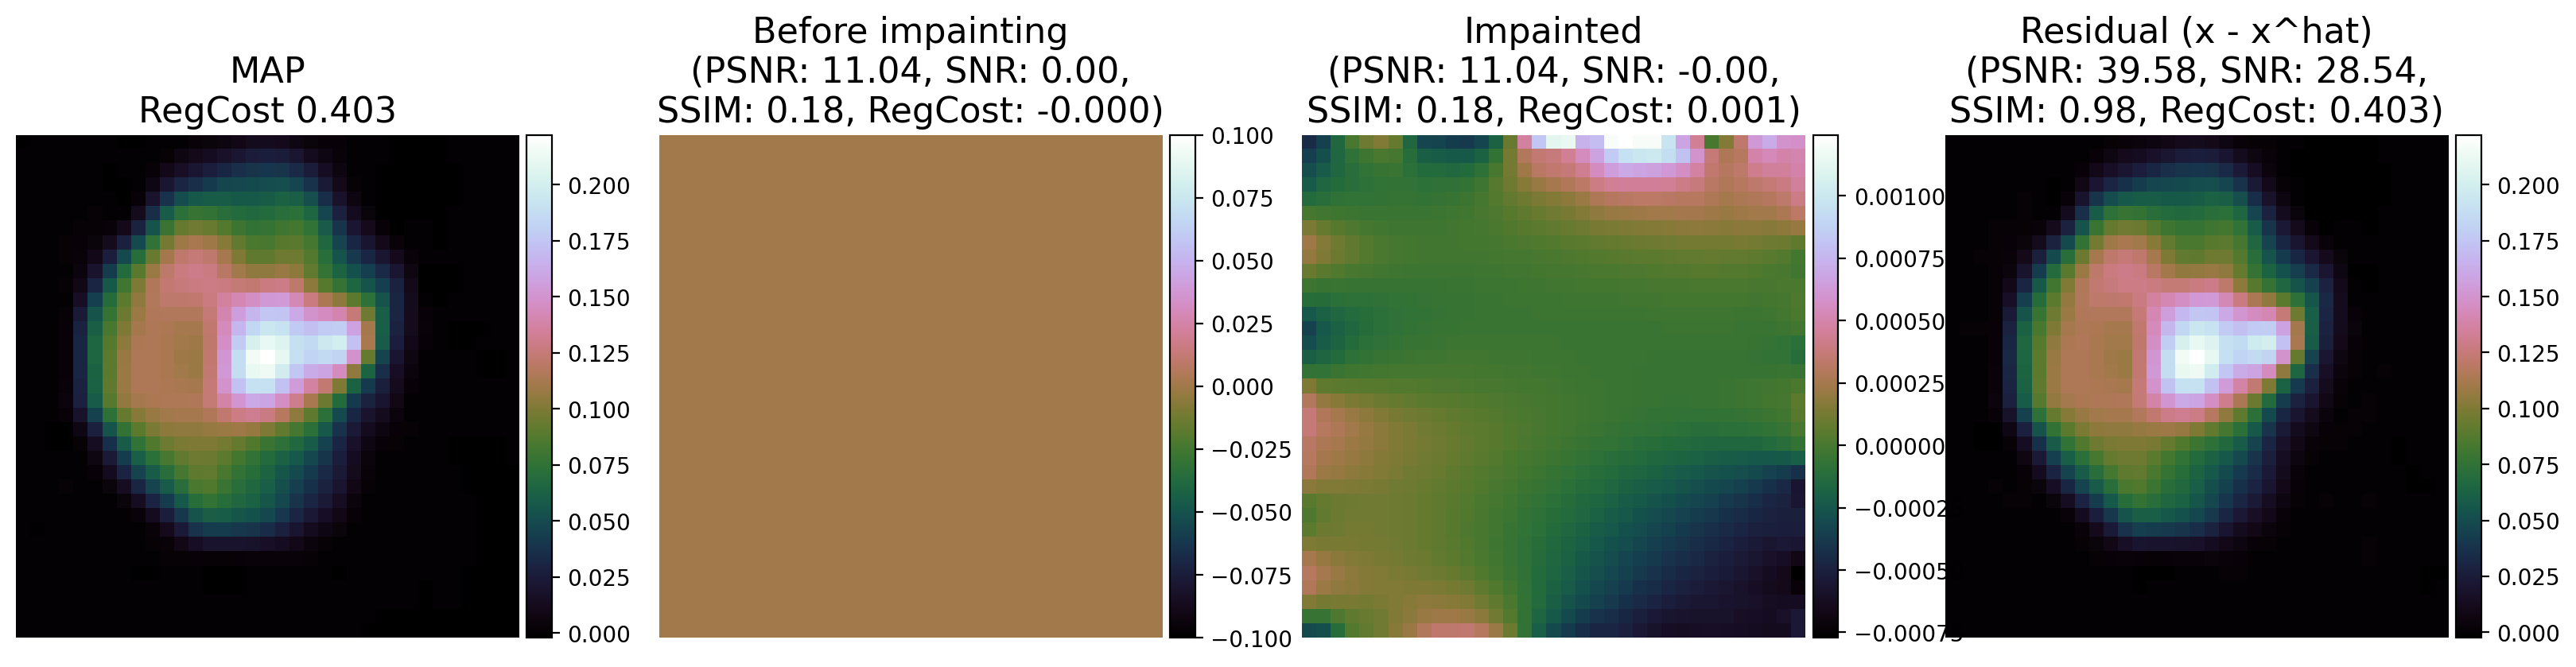

In [36]:

np_x_init = mask_np_img(to_numpy(x_init_imp))
np_x = mask_np_img(to_numpy(x_map))
np_x_hat = mask_np_img(to_numpy(x_hat))
np_gt_x = mask_np_img(np.copy(x))

images = [np_x, np_x_init, np_x_hat, np_x - np_x_hat]


# %%
labels = ["MAP", "Before impainting", "Impainted", "Residual (x - x^hat)"]
fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='cubehelix', vmax=np.nanmax(images[i]), vmin=np.nanmin(images[i]))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i == 0:
        stats_str = '\nRegCost {:.3f}'.format(model.cost(to_tensor(mu * images[i], device=device))[0].item())
    if i > 0:   
        stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f}, RegCost: {:.3f})'.format(
            psnr(np_gt_x, images[i], data_range=np_gt_x.max()-np_gt_x.min()),
            luq.utils.eval_snr(np_gt_x, images[i]),
            ssim(np_gt_x, images[i], data_range=np_gt_x.max()-np_gt_x.min()),
            model.cost(to_tensor(mu * images[i], device=device))[0].item(),
            )
    labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
# plt.savefig('{:s}{:s}_lmbd_{:.1e}_optim_MAP.pdf'.format(savefig_dir, img_name, lmbd))
# plt.close()
plt.show()


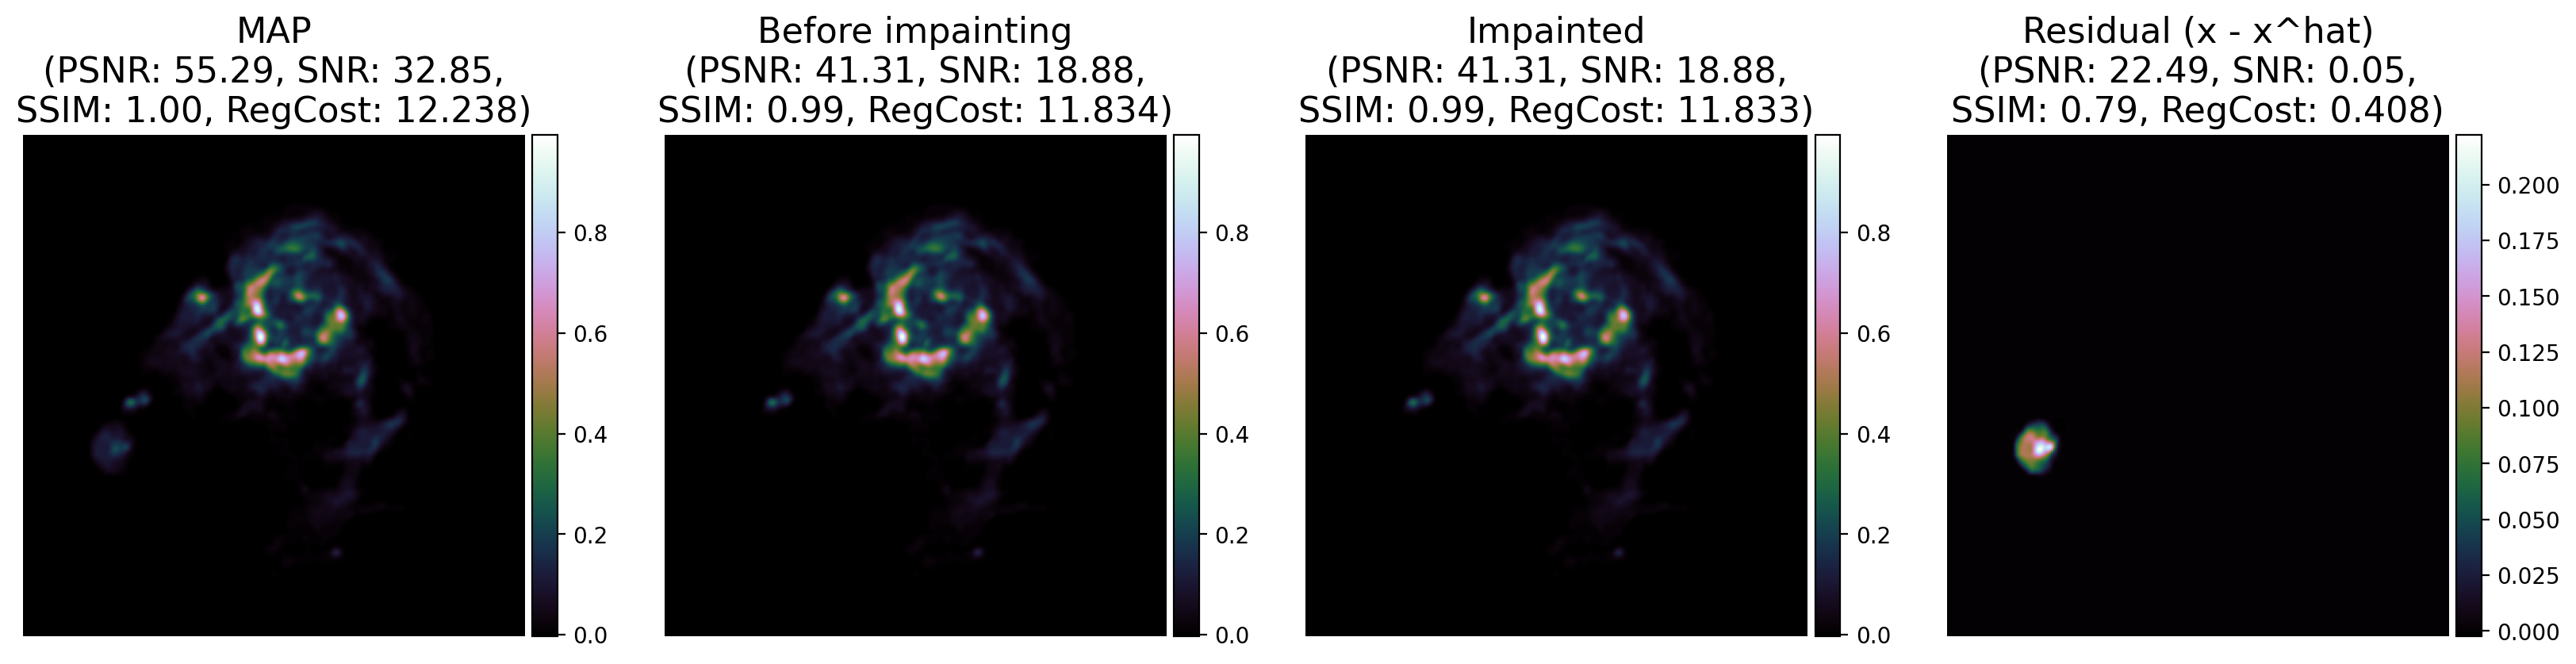

In [37]:
np_x_init = to_numpy(x_init_imp)
np_x = to_numpy(x_map)
np_x_hat = to_numpy(x_hat)
np_gt_x = np.copy(x) 

images = [np_x, np_x_init, np_x_hat, np_x - np_x_hat]


# %%
labels = ["MAP", "Before impainting", "Impainted", "Residual (x - x^hat)"]
fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='cubehelix', vmax=np.nanmax(images[i]), vmin=np.nanmin(images[i]))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    # if i == 0:
    #     stats_str = '\nRegCost {:.3f}'.format(model.cost(to_tensor(mu * images[i], device=device))[0].item())
    if i >= 0:   
        stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f}, RegCost: {:.3f})'.format(
            psnr(np_gt_x, images[i], data_range=np_gt_x.max()-np_gt_x.min()),
            luq.utils.eval_snr(x, images[i]),
            ssim(np_gt_x, images[i], data_range=np_gt_x.max()-np_gt_x.min()),
            model.cost(to_tensor(mu * images[i], device=device))[0].item(),
            )
    labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
# plt.savefig('{:s}{:s}_lmbd_{:.1e}_optim_MAP.pdf'.format(savefig_dir, img_name, lmbd))
# plt.close()
plt.show()


In [38]:
#function handles to used for ULA
def _fun(_x, model, mu, lmbd):
    return (lmbd / mu) * model.cost(mu * _x) + g.fun(_x)

def _grad_fun(_x, g, model, mu, lmbd):
    return  torch.real(g.grad(_x) + lmbd * model(mu * _x))

def _prior_fun(_x, model, mu, lmbd):
    return (lmbd / mu) * model.cost(mu * _x)

# Evaluation of the potentials
fun = partial(_fun, model=model, mu=mu, lmbd=lmbd)
prior_fun = partial(_prior_fun, model=model, mu=mu, lmbd=lmbd)
# Evaluation of the gradient
grad_f = partial(_grad_fun, g=g, model=model, mu=mu, lmbd=lmbd)
# Evaluation of the potential in numpy
fun_np = lambda _x : fun(luq.utils.to_tensor(_x, dtype=myType)).item()

alpha_prob = 0.05
# Compute HPD region bound
N = np_x_hat.size
tau_alpha = np.sqrt(16*np.log(3/alpha_prob))
gamma_alpha = fun(x_map).item() + tau_alpha*np.sqrt(N) + N


In [39]:

print('gamma_alpha: ', gamma_alpha)


gamma_alpha:  100436.80832373202


In [40]:
# Generate surrogate impainted img
surrogate_img = torch.clone(x_hat) * mask_inpainting + torch.clone(x_map) * (1. - mask_inpainting)
# Compute potential
potential = fun(surrogate_img).item()

if potential > gamma_alpha:
    print('Area nonremovable!')
else:
    print('Area removable!')


print('gamma_alpha: ', gamma_alpha)
print('potential: ', potential)


Area nonremovable!
gamma_alpha:  100436.80832373202
potential:  211535.03125


# Image deblurring


In [41]:

kernel_len = (5,5)
size = img.shape

A, AT, AAT_norm = luq.utils.blur_operators(
    kernel_len, size, type_blur='uniform', device=device
)



In [42]:

blurred_map = A(torch.clone(x_map))

blurred_map = torch.clone(blurred_map) * ( torch.max(x_map) / torch.max(blurred_map)) 

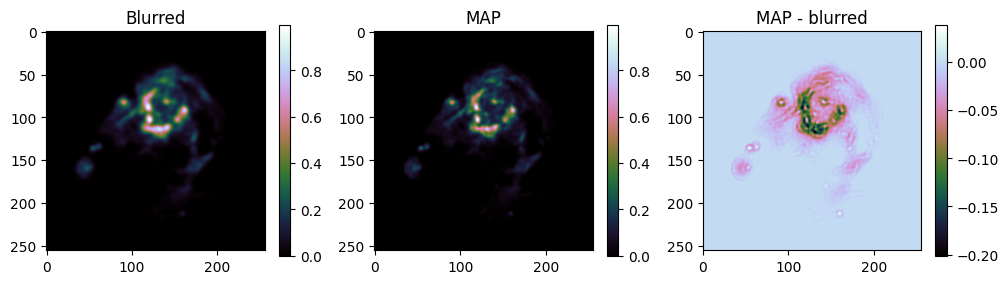

In [43]:
plt.figure(figsize=(12,3))

plt.subplot(131)
plt.imshow(to_numpy(blurred_map), cmap='cubehelix')
plt.colorbar()
plt.title('Blurred')

plt.subplot(132)
plt.imshow(to_numpy(x_map), cmap='cubehelix')
plt.colorbar()
plt.title('MAP')

plt.subplot(133)
plt.imshow(to_numpy(x_map - blurred_map), cmap='cubehelix')
plt.colorbar()
plt.title('MAP - blurred')
plt.show()


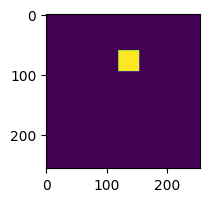

In [44]:
mask_blur_x = [60, 95] # [50,200]# [125, 190]# [145, 180]
mask_blur_y = [120, 155] # [10,150]# [20, 75]# [30, 65]

np_mask_blur = np.zeros((img.shape[0], img.shape[1]))
np_mask_blur[mask_blur_x[0]:mask_blur_x[1], mask_blur_y[0]:mask_blur_y[1]] = 1

plt.figure(figsize=(2,2))
plt.imshow(np_mask_blur)
plt.show()


In [45]:
mask_blur = torch.tensor(
    np_mask_blur, dtype=myType, device=device
).reshape((1,1) + img.shape)


In [46]:


surrogate_blur_im = torch.clone(blurred_map) * mask_blur + torch.clone(x_map) * (1. - mask_blur)



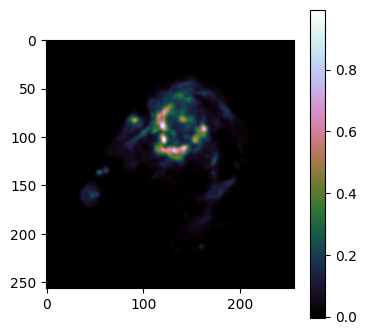

In [47]:

plt.figure(figsize=(4,4))
plt.imshow(to_numpy(surrogate_blur_im), cmap='cubehelix')
plt.colorbar()
plt.show()

In [48]:


# Compute potential
potential = fun(surrogate_blur_im).item()

if potential > gamma_alpha:
    print('Area nonremovable!')
else:
    print('Area removable!')

print('gamma_alpha: ', gamma_alpha)
print('potential: ', potential)


Area nonremovable!
gamma_alpha:  100436.80832373202
potential:  214496.515625
